In [137]:
import numpy as np
import pandas as pd
import pyreadr
import os

import seaborn as sns
import matplotlib.pyplot as plt

BCFTOOLS = "/home/kele/programs/bcftools/bcftools-1.11/bcftools"

def get_ancestry_dosage(arr, n_anc):
    anc_dosage = np.zeros((arr.shape[0], int(arr.shape[1]/2)), dtype=np.half)
    if n_anc==3:
        assert (n_anc==3)
        a0 = arr[:, 0::3] # should be views
        a1 = arr[:, 1::3]
        a2 = arr[:, 2::3]
        anc_dosage[:, 0::3] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::3] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::3] = a2[:, ::2] + a2[:, 1::2]
    elif n_anc==4:
        assert (n_anc==4)
        a0 = arr[:, 0::4] # should be views
        a1 = arr[:, 1::4]
        a2 = arr[:, 2::4]
        a3 = arr[:, 3::4]
        anc_dosage[:, 0::4] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::4] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::4] = a2[:, ::2] + a2[:, 1::2]
        anc_dosage[:, 3::4] = a3[:, ::2] + a3[:, 1::2]   
    return anc_dosage

# True ancestry

def load_true_la(path):
    return np.load(path)['arr']

def get_true_anc_dosage(true_la, n_anc):
    hap1 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    hap2 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    aa = np.arange(true_la[:, ::2].shape[1])*n_anc+true_la[:, ::2]
    bb = np.arange(true_la[:, 1::2].shape[1])*n_anc+true_la[:, 1::2]
    np.put_along_axis(hap1, aa, 1, axis=1)
    np.put_along_axis(hap2, bb, 1, axis=1)
    return hap1+hap2

## Load in the probablistic output of each method
Data frame with one row per site, 

Only every 5 sites represented in this file - not sure if it will always be intervals of 5 sites

After the index columns - each (individual) X (haplotype) X (population) has an entry. 

def load_rfmix_fb(path):
    rfmix_res = pd.read_csv(path, sep='\t', comment='#')
    # expand out to each site
    rfmix_res = np.repeat(rfmix_res.iloc[:, 4:].values, [5], axis = 0)
    return rfmix_res

def load_bmix(path):
    csv_path = path.replace('.vcf.gz', '.csv')
    !{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {path} > {csv_path}
    bmix = pd.read_csv(csv_path, header=None)
    bmix = bmix.dropna(axis=1)
    return(bmix.iloc[:,2:].values)

def load_mosaic(path):
    mr = pyreadr.read_r(path)['arr'].astype(np.half)
    mr = mr.to_numpy().T.reshape((mr.shape[2],-1), order='C')
    return mr

def plot_ancestry_dosage(pred_dosage, start_index, n_anc, reference_dosage=None, title = None):
    """
    only works for 3 ancestries
    """
    colors = ['blue', 'orange', 'green', 'grey']
    
    fig, ax = plt.subplots(figsize = (12, n_anc*1.5), nrows=n_anc, sharex=True, sharey=True)
    
    
    f = []
    for i in range(n_anc):
        l, = ax[i].plot(pred_dosage[:, start_index+i], c=colors[i])
        ax[i].set_ylim([-.05, 2.05])
        f.append(l)
        
    plt.legend(f, [f'pop{p}' for p in range(n_anc)])
    
    if reference_dosage is not None:
        for i in range(n_anc):
            l, = ax[i].plot(reference_dosage[:, start_index+i], c=colors[i], #alpha=.5, 
                            ls='dotted')

    fig.tight_layout()
    sns.despine(bottom=True)
    if title:
        ax[0].set_title(title)
    else:
        ax[0].set_title('Ancestry dosage')
    ax[-1].set_xlabel('Site number ')

## 3 population paths

n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_b/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_b/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_b/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_b/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)

# sum over sites and ancestries?

def get_Q(arr, n_anc):
    nsites = arr.shape[0]
    # avoid overflow and sum over sites
    arr = arr.astype(float).sum(0)
    if n_anc == 3:
        a0 = arr[0::3] # should be views
        a1 = arr[1::3]
        a2 = arr[2::3]
        q0 = (a0[0::2] + a0[1::2])/(nsites*4)
        q1 = (a1[0::2] + a1[1::2])/(nsites*4)
        q2 = (a2[0::2] + a2[1::2])/(nsites*4)
        Q = pd.DataFrame([q0, q1, q2]).T
        Q.columns = ['pop_0', 'pop_1', 'pop_2']
    elif n_anc == 4:
        a0 = arr[0::4] # should be views
        a1 = arr[1::4]
        a2 = arr[2::4]
        a3 = arr[3::4]
        q0 = (a0[0::2] + a0[1::2])/(nsites*4)
        q1 = (a1[0::2] + a1[1::2])/(nsites*4)
        q2 = (a2[0::2] + a2[1::2])/(nsites*4)
        q3 = (a3[0::2] + a3[1::2])/(nsites*4)        
        Q = pd.DataFrame([q0, q1, q2, q3]).T
        Q.columns = ['pop_0', 'pop_1', 'pop_2', 'pop_3']
        
    return(Q)

def get_RMSD_Q(Q1, Q2):
    assert(Q1.shape == Q2.shape)
    D = Q1-Q2
    SD = D*D
    MSD = SD.mean().mean()
    RMSD = np.sqrt(MSD)
    return(RMSD)
    

Q_true = get_Q(true_anc_dosage, n_anc=3)
Q_bmix = get_Q(bmix_anc_dosage, n_anc=3)
Q_mosaic = get_Q(mosaic_anc_dosage, n_anc=3)
Q_rfmix = get_Q(rfmix_anc_dosage, n_anc=3)

rmsd_bmix = get_RMSD_Q(Q_bmix, Q_true)
rmsd_mosaic = get_RMSD_Q(Q_mosaic, Q_true)
rmsd_rfmix = get_RMSD_Q(Q_rfmix, Q_true)

## Write Q results tables
with open('/home/kele/Documents/test.rmsd.tsv', 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['bmix', 'MOSAIC', 'RFMix2' ])  + '\n')
    OUTFILE.write('\t'.join([f'{x:0.4f}' for x in [rmsd_bmix, rmsd_mosaic, rmsd_rfmix]])  + '\n')

Q_true.to_csv('/home/kele/Documents/test.Q.tsv', index = None, sep = '\t', float_format='%0.4f')
Q_true.to_csv('/home/kele/Documents/test.Q.tsv', index = None, sep = '\t', float_format='%0.4f')
Q_true.to_csv('/home/kele/Documents/test.Q.tsv', index = None, sep = '\t', float_format='%0.4f')
Q_true.to_csv('/home/kele/Documents/test.Q.tsv', index = None, sep = '\t', float_format='%0.4f')

In [130]:
f'{rmsd_mosaic:0.4f}'

'0.0109'

In [122]:
rmsd_rfmix

0.00804385361288825

In [116]:
Q1 = get_Q(mosaic_anc_dosage, n_anc=3)
Q2 = get_Q(true_anc_dosage, n_anc=3)
get_RMSD_Q(Q1, Q2)

0.010926389824353401

In [117]:
Q1 = get_Q(bmix_anc_dosage, n_anc=3)
Q2 = get_Q(true_anc_dosage, n_anc=3)
get_RMSD_Q(Q1, Q2)

0.0062484392534367566

In [118]:
Q1 = get_Q(rfmix_anc_dosage, n_anc=3)
Q2 = get_Q(true_anc_dosage, n_anc=3)
get_RMSD_Q(Q1, Q2)

0.00804385361288825

In [114]:
D = Q1-Q2
np.sqrt((D*D).mean().mean())

0.010926389824353401

In [102]:
get_Q(mosaic_anc_dosage, n_anc=3) - get_Q(true_anc_dosage, n_anc=3)

,pop_0,pop_1,pop_2
0,-0.004931,0.009567,-0.004605
1,-0.003093,0.002648,0.000467
2,0.008269,-0.000777,-0.007485
3,-0.001357,0.009089,-0.007718
4,0.000082,-0.001269,0.001202
...,...,...,...
195,0.008388,0.002340,-0.010700
196,-0.029716,-0.000403,0.030151
197,-0.003467,0.001053,0.002432
198,0.018579,-0.040691,0.022128


In [51]:
nsites = mosaic_anc_dosage.shape[0]
arr = mosaic_anc_dosage.astype(float).sum(0)
a0 = arr[0::3] # should be views
a1 = arr[1::3]
a2 = arr[2::3]

In [61]:
# sum over adjacent haploids to make inds
q0 = (a0[0::2] + a0[1::2])/(nsites*4)
q1 = (a1[0::2] + a1[1::2])/(nsites*4)
q2 = (a2[0::2] + a2[1::2])/(nsites*4)

In [93]:
# make a file for output
Q = pd.DataFrame([q0, q1, q2]).T
Q.columns = ['pop_0', 'pop_1', 'pop_2']
Q

,pop_0,pop_1,pop_2
0,0.046901,0.312707,0.640423
1,0.103104,0.702063,0.194855
2,0.286329,0.395445,0.318233
3,0.088583,0.272782,0.638650
4,0.123484,0.239906,0.636625
...,...,...,...
195,0.254385,0.140707,0.604935
196,0.137004,0.430937,0.432091
197,0.003920,0.580381,0.415717
198,0.186789,0.280101,0.533125


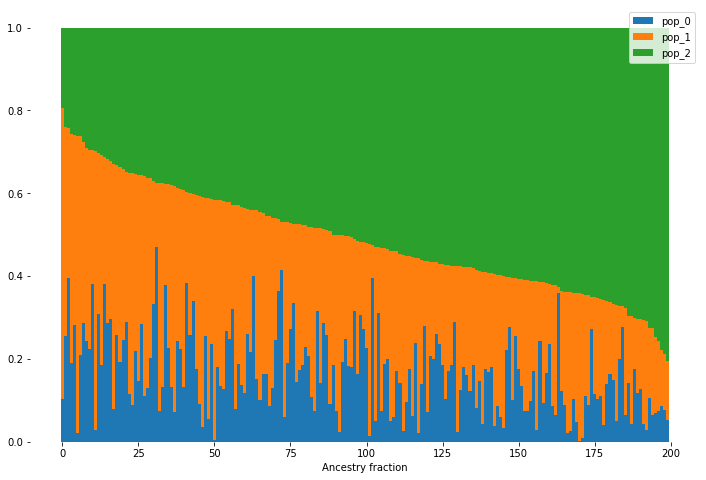

In [85]:
plt.subplots(figsize = (12, 8))
order = np.argsort(q2)
plt.bar(np.arange(len(q0)), q0[order], width=1, label='pop_0')
plt.bar(np.arange(len(q1)), q1[order], width=1, bottom = q0[order], label='pop_1')
plt.bar(np.arange(len(q2)), q2[order], width=1, bottom = q0[order]+q1[order], label='pop_2')
sns.despine(bottom=True, left=True)
plt.xlabel("Individuals")
plt.xlabel("Ancestry fraction")
plt.legend()

<AxesSubplot:ylabel='Count'>

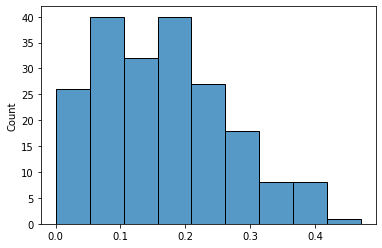

In [64]:
sns.histplot(q0)

(<AxesSubplot:ylabel='Count'>,
 <AxesSubplot:ylabel='Count'>,
 <AxesSubplot:ylabel='Count'>)

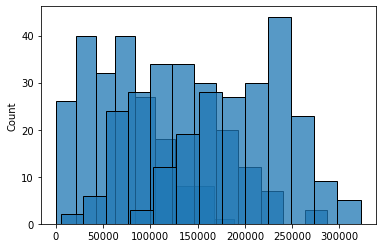

In [50]:
sns.histplot(q0), sns.histplot(q1), sns.histplot(q2)

In [32]:
q0 = a0[:, 0::2] + a0[:, 1::2]
q1 = a1[:, 0::2] + a1[:, 1::2]
q2 = a2[:, 0::2] + a2[:, 1::2]


In [38]:
a2

array([[1.003   , 1.004   , 0.00962 , ..., 1.006   , 0.979   , 1.022   ],
       [1.003   , 1.004   , 0.00962 , ..., 1.006   , 0.979   , 1.022   ],
       [1.003   , 1.004   , 0.00962 , ..., 1.006   , 0.979   , 1.022   ],
       ...,
       [1.002   , 1.307   , 1.204   , ..., 0.001721, 1.001   , 0.9883  ],
       [1.002   , 1.307   , 1.204   , ..., 0.001721, 1.001   , 0.9883  ],
       [1.002   , 1.307   , 1.204   , ..., 0.001721, 1.001   , 0.9883  ]],
      dtype=float16)

In [42]:
mosaic_anc_dosage.astype(float).sum(0)

(1200,)

In [39]:
np.sum(a2.astype(float), axis =0)

array([139205.75537109, 116963.29970574,  74215.79523498,   3726.1422596 ,
       105585.67582333,  21707.38216597, 121865.69941777, 133594.22140503,
       156376.59960938,  98273.3650108 ,  63350.13403177,  61264.34859151,
        21236.80992514,  82100.73485994, 107703.23568082, 100120.36099488,
        47749.6817894 ,  93794.71853012,  34207.49384373, 153351.4309082 ,
       121250.82788181,  92367.90706474, 123166.88397527,  89193.88900483,
        71066.83932632,  76922.32196146, 119875.84150708,  95993.79759097,
       132037.53245986,  57331.34777075,  39974.7577408 , 110067.17748773,
        88609.31392252, 160092.44726562, 187104.04394531,  94379.84603882,
        85029.18345302, 149321.06588125,  53210.01631844,  86834.94684583,
        92449.44330668, 150040.67687988,  88269.27910608,  78336.69082648,
       114740.45481771, 124873.96936035,  36341.77805418, 127572.53631592,
        93521.86825889,  48496.42465264, 116929.60321319, 120517.79150391,
       125368.18310422,  

<AxesSubplot:ylabel='Count'>

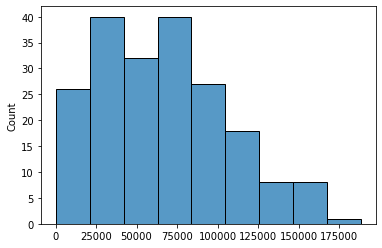

In [31]:
sns.histplot(np.sum(tt.astype(float), axis = 0))

In [40]:
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9599919101878823 [0.9719455786975292, 0.9491044134245316, 0.9589257384415861]
MOSAIC
0.952388049019449 [0.9496574674144709, 0.9528247920250454, 0.9546818876188308]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz.csi
bmix
0.9766295813660376 [0.9805596161176274, 0.9725791116714588, 0.9767500163090264]


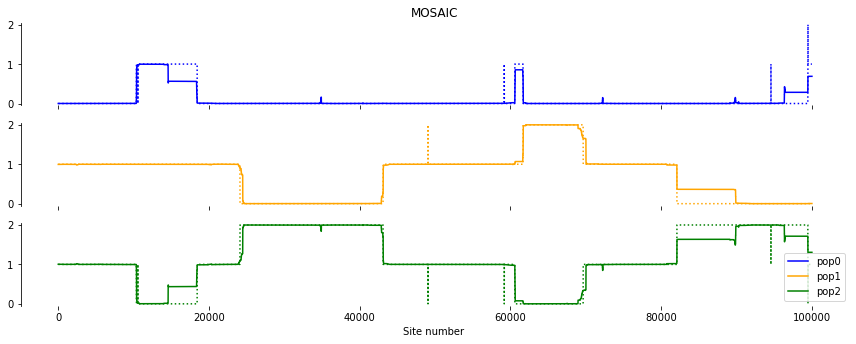

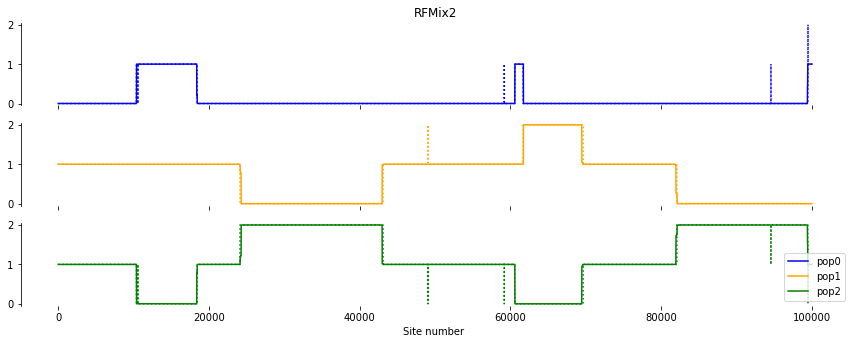

In [45]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

In [26]:
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_d/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_d/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_d/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_d/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_d/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9653883706281556 [0.9761054985034314, 0.9548585771033388, 0.9652010362776967]
MOSAIC
0.8841202809364531 [0.9329766311265839, 0.8537489477188244, 0.8656352639639514]
[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)
bmix
0.9753054395439982 [0.9749437039910106, 0.9774582723397397, 0.9735143423012445]


In [46]:
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_e/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_e/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_e/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_e/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9665838263030296 [0.972789240693921, 0.9590413026741804, 0.9679209355409876]
MOSAIC
-0.43315582197668134 [-1.113255980114801, -0.16498157324535612, -0.021229912569886933]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz.csi
bmix
0.9799313390448082 [0.9819105788200673, 0.9759578765963072, 0.9819255617180503]


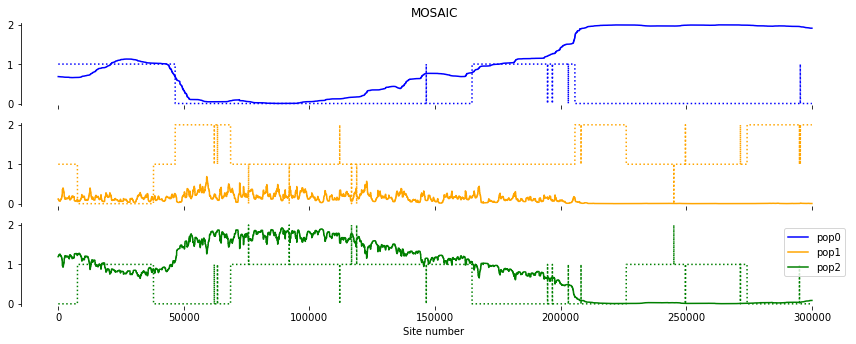

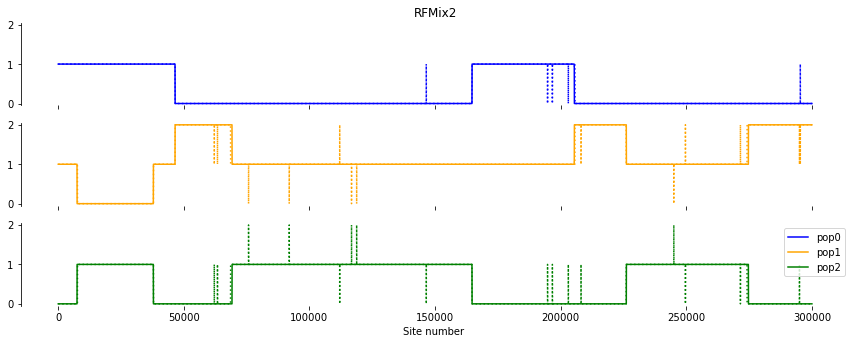

In [47]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

In [34]:
print('3pop_b, PEARSON')
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_b/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_b/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_b/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_b/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

3pop_b, PEARSON
RFMix2
0.9799787368983138 [0.9859932490366351, 0.9745116860459441, 0.9794312756123621]
MOSAIC
0.975984632655901 [0.9746128773454565, 0.9761953124836382, 0.977145708138608]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz.csi
bmix
0.9883154343613062 [0.9902719183877408, 0.9862960632798814, 0.9883783214162966]


In [35]:
print('3pop_d, PEARSON')

n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_d/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_d/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_d/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_d/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_d/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

3pop_d, PEARSON
RFMix2
0.9827173843334919 [0.9880707169242702, 0.9774652951946659, 0.9826161408815395]
MOSAIC
0.9411401134755919 [0.9663470146372822, 0.9253819133454653, 0.931691412444028]
[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)
bmix
0.9877384567647445 [0.9876174152318233, 0.9887511695010742, 0.986846785561336]


In [36]:
print('3pop_e, PEARSON')

n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_e/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_e/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_e/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_e/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

3pop_e, PEARSON
RFMix2
0.9832950210080259 [0.9864079589948922, 0.9795283743374978, 0.9839487296916878]
MOSAIC
0.485981247509592 [0.48455383951706443, 0.4692988576940523, 0.5040910453176592]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz.csi
bmix
0.9899436418809432 [0.9909546822120023, 0.9879383792793492, 0.9909378641514778]


## 4 population paths

In [ ]:
n_anc=4
base_path = "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/true_local_ancestry.site_matrix.npz"
rf_fb_path =  "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/RFMix2/rfmix2.fb.tsv"
mosaic_path = '/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/MOSAIC/la_probs.RData'
bmixpath = '/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/bmix/bmix.anc.vcf.gz'

# TODO
    - move to Snakemake
    - write out the diploid ancestry dosage matrices
    - write out the accuracy for each in a file

In [50]:
n_anc=3
base_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/bmix/bmix.anc.vcf.gz'


In [51]:
true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)


In [52]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9623839622451981,
 [0.9705562736879104, 0.953021601927494, 0.9635740111201896])

In [53]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9623839622451981,
 [0.9705562736879104, 0.953021601927494, 0.9635740111201896])

In [54]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
np.mean(mosaic_anc_r2), mosaic_anc_r2

(0.957680114385168,
 [0.9579496426109032, 0.954251506428117, 0.9608391941164838])

In [55]:
bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
np.mean(bmix_anc_r2), bmix_anc_r2

(0.9789473261634574,
 [0.9851471720740084, 0.9722837452478683, 0.9794110611684953])

In [56]:
#plot_ancestry_dosage(true_anc_dosage, start_index=0, n_anc=n_anc, reference_dosage=None)

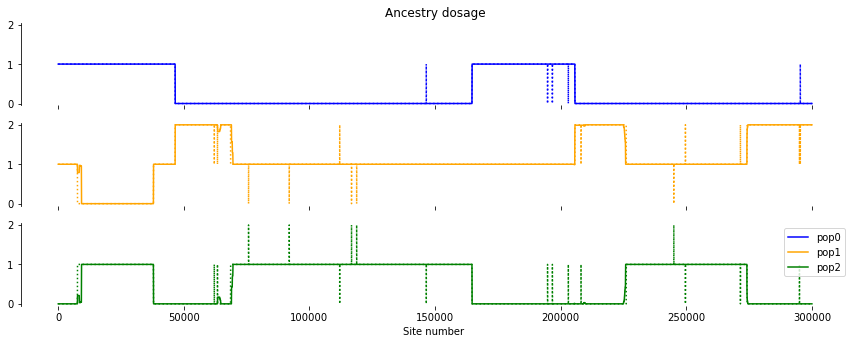

In [37]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

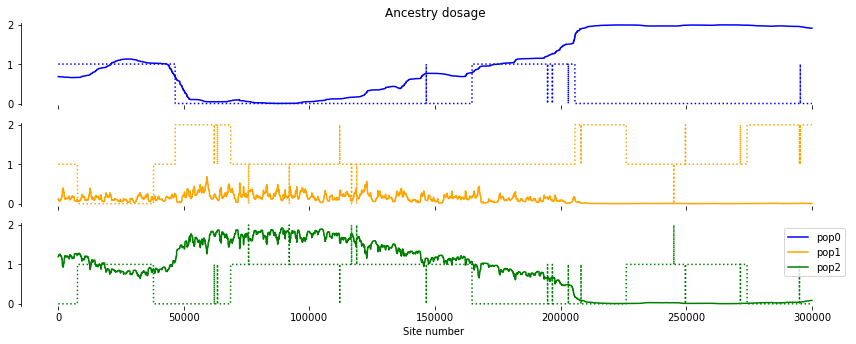

In [38]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

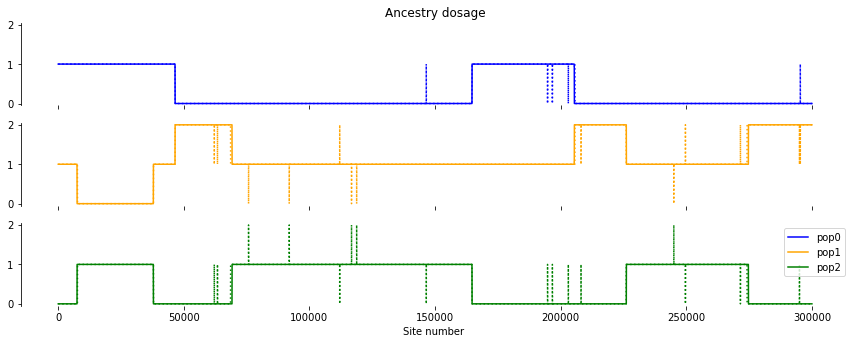

In [39]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

In [41]:
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_d/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_d/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_d/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_d/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_d/bmix/bmix.anc.vcf.gz'

In [42]:
true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)


In [43]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9653883706281556,
 [0.9761054985034314, 0.9548585771033388, 0.9652010362776967])

In [44]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9653883706281556,
 [0.9761054985034314, 0.9548585771033388, 0.9652010362776967])

In [45]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
np.mean(mosaic_anc_r2), mosaic_anc_r2

(0.8841202809364531,
 [0.9329766311265839, 0.8537489477188244, 0.8656352639639514])

In [46]:
bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
np.mean(bmix_anc_r2), bmix_anc_r2

[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)


(0.9753054395439982,
 [0.9749437039910106, 0.9774582723397397, 0.9735143423012445])

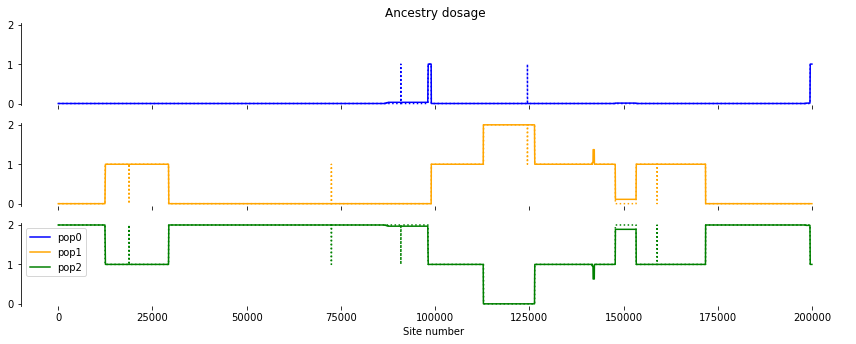

In [47]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

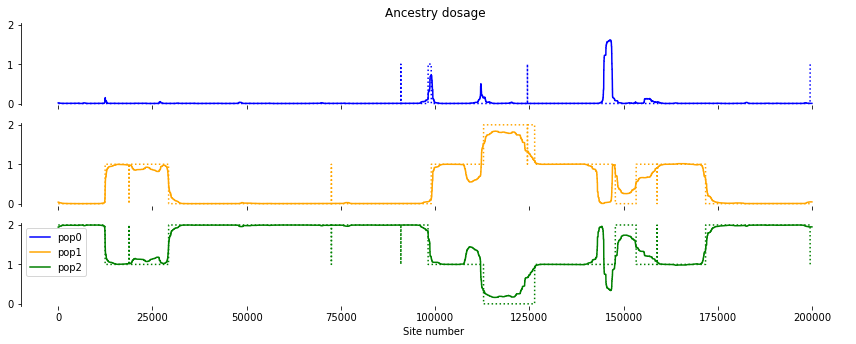

In [48]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

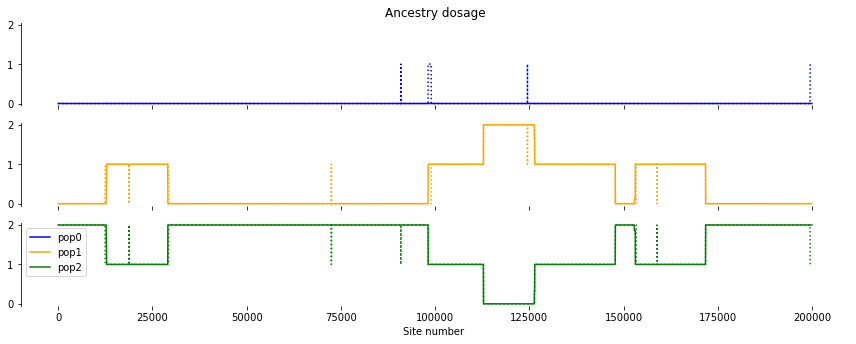

In [49]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

In [ ]:
plot_ancestry_dosage(true_anc_dosage, start_index=0, n_anc=n_anc, reference_dosage=None)

In [ ]:
plot_ancestry_dosage(bmix_anc_dosage , start_index=4, n_anc=n_anc, reference_dosage=true_anc_dosage)

In [ ]:
plot_ancestry_dosage(mosaic_anc_dosage , start_index=4, n_anc=n_anc, reference_dosage=true_anc_dosage)

## Why is mosaic failing

In [ ]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)


In [ ]:
import glob 
mosaic_path = glob.glob('/home/kele/Documents/lai/lai-sim/results/*/*/*/MOSAIC/*.RData')[1]
#pyreadr.read_r(mosaic_path)

In [ ]:
#load_mosaic(mosaic_path)

In [ ]:
!ls /home/kele/3pop_c/MOSAIC/*.RData

In [ ]:
# run in R
library('MOSAIC')

model_results = '/home/kele/3pop_c/MOSAIC/admixed.RData'
la_results = '/home/kele/3pop_c/MOSAIC/localanc_admixed.RData'
mosaic_input_dir = '/home/kele/3pop_c/MOSAIC/input/'

load(model_results)
load(la_results)
# localanc gives the local ancestry at each grid point
# get local ancestry probabilities at each SNP
local_pos=grid_to_pos(localanc, mosaic_input_dir, g.loc, chrnos)
dims = dim(local_pos[[1]])
# convert to array and then export
arr = array(unlist(local_pos, use.names=FALSE), dims)

In [ ]:
arr2 = array(unlist(local_pos, use.names=FALSE), dims)

In [ ]:
output_path = '/home/kele/3pop_c/MOSAIC/la_probs2.RData'
save(arr, file = output_path)
#save(arr, file = simple_output)

In [ ]:
#pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs2.RData', use_objects=['arr'])
pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs.rds')

In [ ]:
pyreadr.read_r('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_5/MOSAIC/la_probs.RData')


In [ ]:
pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs2.RData', use_objects=['arr'])

In [ ]:
true_anc_dosage

In [ ]:
bb = load_true_la(true_path)
bb.shape

In [ ]:
!wc -l /home/kele/3pop_c/site.positions


In [ ]:
aa

In [ ]:
sqdif = ((true_anc_dosage - bmix_anc_dosage).astype('float')**2).sum().sum()

In [ ]:
sqdif/ (true_anc_dosage.shape[0]*true_anc_dosage.shape[1])

In [ ]:
np.sqrt(sqdif/(true_anc_dosage.shape[0]*true_anc_dosage.shape[1]))

In [ ]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
plt.show()
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

In [ ]:
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

In [ ]:
## Write R2 tables
with open(os.path.join(base_path, 'R2_score.ancestry.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'anc_{x}' for x in range(nanc)]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_anc_r2])  + '\n')
    
with open(os.path.join(base_path, 'R2_score.individuals.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'ind_{x}' for x in range(len(bmix_ind_r2))]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_ind_r2])  + '\n')

In [ ]:
assert False

In [ ]:
plot_ancestry_dosage(true_anc_dosage, start_index=3, reference_dosage=None)

In [ ]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

In [ ]:
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    nanc=3
)
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

# Mosaic
Data frame with one row per site. 
after the index columns - each (individual) X (haplotype) X (ancestry) has an entry. 

In [ ]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

In [ ]:
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)
sns.histplot(mosaic_ind_r2)
plt.show()
plt.scatter(np.arange(len(mosaic_ind_r2)), sorted(mosaic_ind_r2))
np.mean(mosaic_anc_r2), np.mean(mosaic_ind_r2)

In [ ]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

# bmix

In [ ]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

In [ ]:
!{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {bmixpath} > {bmixpath.replace('.vcf.gz', '.csv')}

In [ ]:
bmix = pd.read_csv(bmixpath.replace('.vcf.gz', '.csv'), header = None)
bmix = bmix.dropna(axis=1)
bmix = bmix.iloc[:,2:]
bmix_anc_dosage = get_ancestry_dosage(bmix.values)

In [ ]:
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

In [ ]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
np.where(bmix_ind_r2 == np.min(bmix_ind_r2))
plt.show()

In [ ]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

## There is not a huge correlation in the indiviudal level accuracy of the various methods here

In [ ]:
r2_df = pd.DataFrame(data = {'bmix':bmix_ind_r2, 'rfmix':rfmix_ind_r2, 'mosaic':mosaic_ind_r2})

In [ ]:
pearsonr(r2_df['bmix'], r2_df['mosaic'])[0]**2, pearsonr(r2_df['bmix'], r2_df['rfmix'])[0]**2, pearsonr(r2_df['mosaic'], r2_df['rfmix'])[0]**2

In [ ]:
sns.pairplot(r2_df,
             plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'k'})

In [ ]:
sns.jointplot(data = r2_df, x='bmix', y='rfmix', color="#4CB391", kind="reg")

In [ ]:
def plot_ancestry_dosage(pred_dosage, start_index, n_anc, reference_dosage=None):
    """
    only works for 3 ancestries
    """
    fig, ax = plt.subplots(figsize = (12, n_anc*1.5), nrows=n_anc, sharex=True, sharey=True)
    
    l0, = ax[0].plot(pred_dosage[:, start_index+0], c='b')
    l1, = ax[1].plot(pred_dosage[:, start_index+1], c='orange')
    l2, = ax[2].plot(pred_dosage[:, start_index+2], c='green')
    
    plt.legend([l0, l1, l2], ['pop0', 'pop1', 'pop2'])

    
    if reference_dosage is not None:
        l0, = ax[0].plot(reference_dosage[:, start_index+0], c='b', alpha=.5, ls='--')
        l1, = ax[1].plot(reference_dosage[:, start_index+1], c='orange', alpha=.5, ls='--')
        l2, = ax[2].plot(reference_dosage[:, start_index+2], c='green', alpha=.5, ls='--')

    fig.tight_layout()
    sns.despine(bottom=True)
    ax[0].set_title('Ancestry dosage')
    ax[-1].set_xlabel('Site number ')